# Multi-height wind data

In this example we explore the calculation of multi-height wind data, as for example obtained from WRF results or downloaded from the [NEWA website](https://map.neweuropeanwindatlas.eu/) at a single point.

Here we will use the static data file `WRF-Timeseries-3000.nc` that is part of the `foxes` static data.
The time coordinate marks one month in 10 minute steps, and the wind speed (WS), wind direction (WD) and turbulent intensity (TI) are provided at 8 heights between 50 and 500 m. The air density (RHO) does not have height dependency but varies with time. The detailed data structure will be displayed below.

The basic assumption of this example is that we can calculate our wind farm results based on this data, i.e., that the horizontal variation can be neglected (for completely heterogeneous inflow data, see the corresponding example).

These are the imports for this example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from xarray import open_dataset

import foxes
import foxes.variables as FV

In [2]:
engine = foxes.Engine.new("default")

First, we setup the model book and the wind farm. We choose 5 turbines in a row:

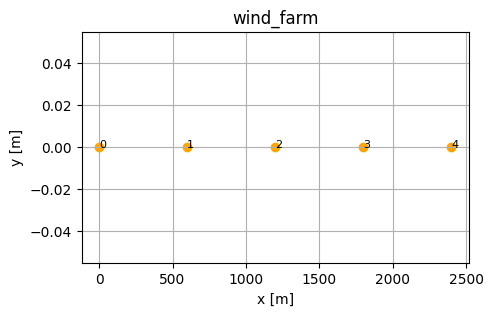

In [3]:
# create wind farm, a single row of turbines:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0.0, 0.0],
    xy_step=[600.0, 0.0],
    n_turbines=5,
    turbine_models=["NREL5MW"],
    H=200.0,
    verbosity=0,
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(5, 3))
plt.show()

Note that we manually change the hub height from 90 m to 200 m here. Next, we create the states based on the static data file `WRF-Timeseries-3000.nc`:

In [4]:
# This is what the nc file looks like:
fpath = foxes.StaticData().get_file_path(foxes.STATES, "WRF-Timeseries-3000.nc")
with open_dataset(fpath) as ds:
    print(ds)

<xarray.Dataset> Size: 528kB
Dimensions:  (Time: 3000, height: 8)
Coordinates:
  * Time     (Time) <U19 228kB '2009-01-01 00:00:00' ... '2009-01-21 19:50:00'
  * height   (height) float32 32B 50.0 75.0 90.0 100.0 150.0 200.0 250.0 500.0
Data variables:
    ws       (Time, height) float32 96kB ...
    wd       (Time, height) float32 96kB ...
    ti       (Time, height) float32 96kB ...
    rho      (Time) float32 12kB ...


Now let's create the corresponding states object:

Selecting 'DefaultEngine(n_procs=16, chunk_size_states=None, chunk_size_points=None)'
DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 3000 states for 1 turbines
SingleChunkEngine: Starting calculation using a single worker.
SingleChunkEngine: Completed all 1 chunks



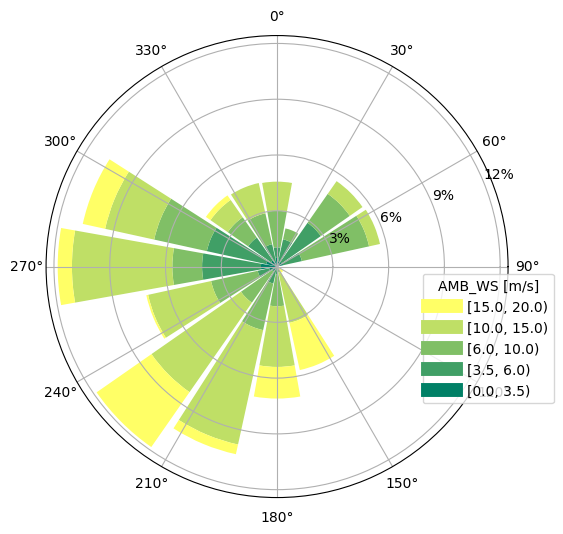

In [5]:
states = foxes.input.states.MultiHeightNCTimeseries(
    data_source="WRF-Timeseries-3000.nc",
    time_coord="Time",
    h_coord="height",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.TI: "ti", FV.RHO: "rho"},
)

o = foxes.output.StatesRosePlotOutput(states, point=[0.0, 0.0, 100.0])
o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

Note how the `var2col` option offers a mapping from the expected to the actual column names, if needed.

Let's next setup our algorithm. Notice that we include the z-sensitive rotor model `level10`, with 10 points on a vertical line (also the `grid` models would be an option). The partial wakes choice `None` represents default settings for all wake models. It is important that we do not select `rotor_points` together with the `level10` rotor, since averaging over a vertical line of points does not make much sense.

In [6]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="level10",
    wake_models=["Bastankhah2014_linear_ka02"],
    partial_wakes=None,
    verbosity=0,
)

We now visualize the vertical flow profile for a single selected state:

In [7]:
farm_results = algo.calc_farm()

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 3000 states for 5 turbines
SingleChunkEngine: Starting calculation using a single worker.


SingleChunkEngine: Completed all 1 chunks



In [8]:
fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.REWS, FV.P]])

                                     WD      REWS            P
state               turbine                                   
2009-01-01 00:00:00 0        340.149890  7.593225  1460.198707
                    1        340.149890  7.593225  1460.198707
                    2        340.149890  7.593225  1460.198707
                    3        340.149890  7.593225  1460.198707
                    4        340.149890  7.593225  1460.198707
...                                 ...       ...          ...
2009-01-21 19:50:00 0        201.692583  7.628299  1512.458987
                    1        201.692583  7.628299  1512.458987
                    2        201.692583  7.628299  1512.458987
                    3        201.692583  7.628299  1512.458987
                    4        201.692583  7.628299  1512.458987

[15000 rows x 3 columns]


States 'MultiHeightNCTimeseries': Reading file /home/jonas/gits/wakes/foxes/foxes/data/states/WRF-Timeseries-3000.nc
DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating data at 4646 points for 1 states
ProcessEngine: Starting calculation using 15 workers, for 1 states chunks and 15 targets chunks.


  0%|                                                                                                   | 0/15 [00:00<?, ?it/s]

  7%|██████                                                                                     | 1/15 [00:00<00:01,  8.15it/s]

 40%|████████████████████████████████████▍                                                      | 6/15 [00:00<00:00, 29.97it/s]

 73%|██████████████████████████████████████████████████████████████████                        | 11/15 [00:00<00:00, 38.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.55it/s]

ProcessEngine: Completed all 15 chunks



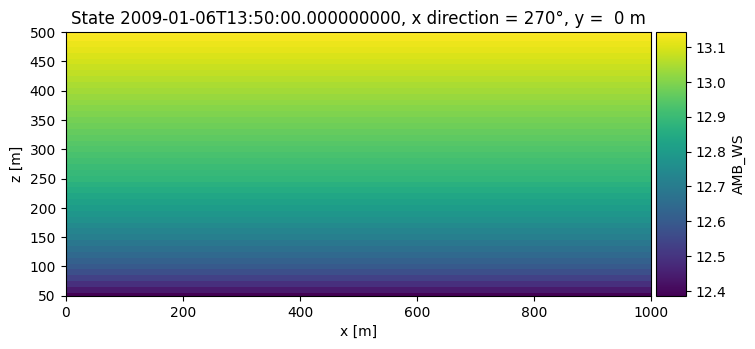

In [9]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xz(
    FV.AMB_WS,
    resolution=10,
    x_direction=270,
    xmin=0.0,
    xmax=1000.0,
    zmin=50.0,
    zmax=500.0,
    figsize=(8, 6),
    states_sel=["2009-01-06 13:50:00"],
)
fig = next(g)
plt.show()

Let's look at the mean REWS results for each turbine:

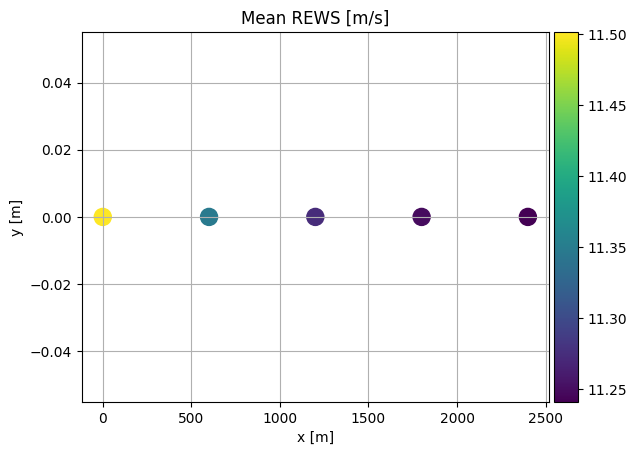


Farm power        : 14.8 MW
Farm ambient power: 15.2 MW
Farm efficiency   : 97.27 %
Annual farm yield : 129.93 GWh


In [10]:
o = foxes.output.FarmLayoutOutput(farm, farm_results)
o.get_figure(color_by="mean_REWS", title="Mean REWS [m/s]", s=150, annotate=0)
plt.show()

o = foxes.output.FarmResultsEval(farm_results)
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power        : {P / 1000:.1f} MW")
print(f"Farm ambient power: {P0 / 1000:.1f} MW")
print(f"Farm efficiency   : {o.calc_farm_efficiency() * 100:.2f} %")
print(f"Annual farm yield : {o.calc_farm_yield(algo=algo):.2f} GWh")

Finally we close the engine:

In [11]:
engine.finalize()